In [1]:
import numpy as np
import torch
import cv2
import os
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
DataPath = "flower_images"
dic = {'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}

image_path = []
image_labels = []

for name, label in dic.items():
  path = os.path.join(DataPath, name)
  for f in os.listdir(path):
    image_path.append(os.path.join(name, f))
    image_labels.append(label)

In [3]:
class FlowersDataset(Dataset):
    def __init__(self, file_list, file_label, dir, transform=None):
        self.file_list = file_list
        self.file_label = file_label
        self.dir = dir
        self.transform = transform
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        #считываем изображение
        image = cv2.imread(os.path.join(self.dir, self.file_list[idx]))
        #делаем изображение RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #присваиваем лейбл каждой картинке
        self.label = self.file_label[idx]
        image = self.transform(image)
        
        return image, float(self.label)

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])
data = FlowersDataset(image_path, image_labels, DataPath, transform)
train_size = int(len(data) * 0.2)
train_set, test_set = torch.utils.data.random_split(data, (len(data) - train_size, train_size))
trainloader = torch.utils.data.DataLoader(train_set, pin_memory=True, 
                                        batch_size = 64, shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(test_set, batch_size = 64, num_workers=0)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()
epoch = 10

In [6]:
def train(model, dataloader, criterion, optimizer, epochs, device):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracy = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for _, (data, target) in tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}"):
            data = data.to(device)
            target = target.to(device).long()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Подсчет точности
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        epoch_loss /= len(dataloader)
        train_losses.append(epoch_loss)
        accuracy = 100 * correct / total
        train_accuracy.append(accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return (train_losses, train_accuracy)

def validate(model, testloader, device):
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    # Зададим параметры, чтобы модель не считала градиенты
    with torch.no_grad():
        # переводим модель в режим "оценивания"
        model.eval()
        for images, labels in testloader:
            # прогоняем изображения через модель
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # получим максимальное значение (это и будет наш лейбл)
            predicted = torch.max(outputs.data, 1)[1]
            # Посчитаем количество лейблов
            total += len(labels)
            # Посчитаем количество правильных предиктов
            correct += (predicted == labels).sum()

            # Сохраним все лейблы и предсказания для дальнейшего анализа
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / float(total)
    print('Accuracy: {:.2f} %'.format(accuracy))

    # Преобразуем списки в numpy массивы для удобства
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Получим уникальные классы
    classes = np.unique(np.concatenate((all_labels, all_predictions)))
    num_classes = len(classes)
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}

    # Инициализируем матрицу ошибок
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Заполним матрицу ошибок
    for t, p in zip(all_labels, all_predictions):
        conf_matrix[class_to_index[t], class_to_index[p]] += 1

    # Нормализуем матрицу ошибок
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Вычислим precision и recall для каждого класса
    precision_per_class = []
    recall_per_class = []

    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precision_per_class.append(precision)
        recall_per_class.append(recall)

    # Усредненные precision и recall
    precision = np.mean(precision_per_class)
    recall = np.mean(recall_per_class)

    np.set_printoptions(precision=2)

    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('Confusion Matrix (Normalized):')
    print(conf_matrix_normalized)

def plot_data(loss, accuracy):
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 25 * 25)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def save_model(self, path):
        torch.save(self.state_dict(), path)
        print(f'Model saved to {path}')

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()  # перевести модель в режим оценки
        print(f'Model loaded from {path}')

In [8]:
cnnModel = CNN()
optimizer = optim.Adam(cnnModel.parameters())
(loss, accuracy) = train(cnnModel, trainloader, criterion, optimizer, epoch, device)
cnnModel.save_model('cnnModel.pt')
cnnModel.load_model('cnnModel.pt')

Epoch 1/10: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]


Epoch 1, Train Loss: 1.4323, Accuracy: 38.83%


Epoch 2/10: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


Epoch 2, Train Loss: 1.0756, Accuracy: 57.35%


Epoch 3/10: 100%|██████████| 125/125 [00:18<00:00,  6.63it/s]


Epoch 3, Train Loss: 0.8449, Accuracy: 67.35%


Epoch 4/10: 100%|██████████| 125/125 [00:19<00:00,  6.57it/s]


Epoch 4, Train Loss: 0.6608, Accuracy: 76.10%


Epoch 5/10: 100%|██████████| 125/125 [00:18<00:00,  6.62it/s]


Epoch 5, Train Loss: 0.4589, Accuracy: 84.12%


Epoch 6/10: 100%|██████████| 125/125 [00:19<00:00,  6.55it/s]


Epoch 6, Train Loss: 0.3109, Accuracy: 89.88%


Epoch 7/10: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


Epoch 7, Train Loss: 0.1912, Accuracy: 94.42%


Epoch 8/10: 100%|██████████| 125/125 [00:18<00:00,  6.61it/s]


Epoch 8, Train Loss: 0.1242, Accuracy: 96.58%


Epoch 9/10: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


Epoch 9, Train Loss: 0.0912, Accuracy: 97.40%


Epoch 10/10: 100%|██████████| 125/125 [00:19<00:00,  6.27it/s]

Epoch 10, Train Loss: 0.0638, Accuracy: 98.38%
Model saved to cnnModel.pt
Model loaded from cnnModel.pt


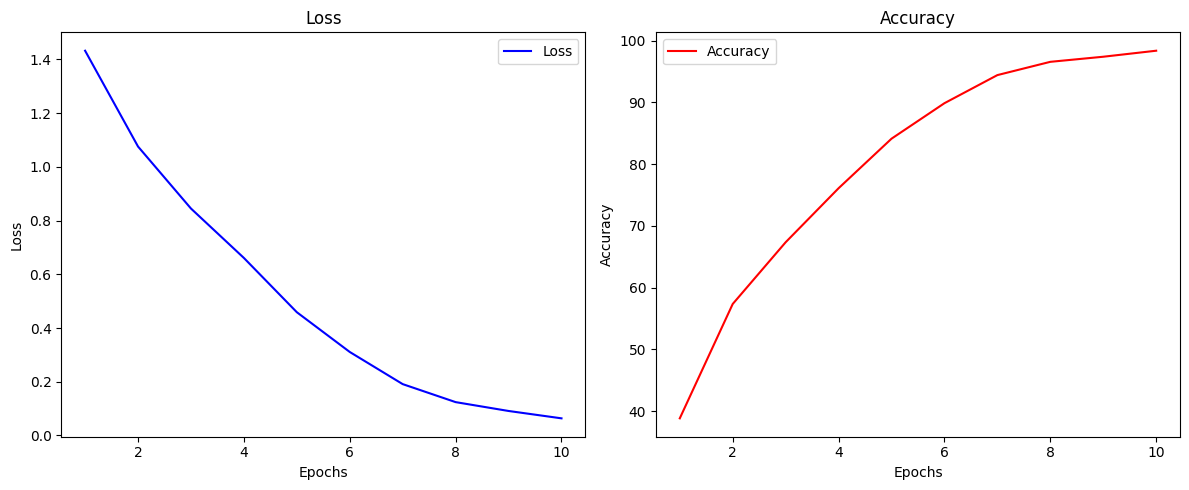

In [9]:
plot_data(loss, accuracy)

In [10]:
validate(cnnModel, testloader, device)

Accuracy: 82.60 %
Precision: 0.83
Recall: 0.83
Confusion Matrix (Normalized):
[[0.73 0.1  0.08 0.01 0.08]
 [0.04 0.89 0.04 0.   0.03]
 [0.08 0.09 0.76 0.01 0.06]
 [0.   0.01 0.01 0.96 0.03]
 [0.03 0.07 0.07 0.02 0.81]]


In [8]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)  # 5 классов
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 12 * 12)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x
    
    def save_model(self, path):
        torch.save(self.state_dict(), path)
        print(f'Model saved to {path}')

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()  # перевести модель в режим оценки
        print(f'Model loaded from {path}')

In [9]:
improvedCNNModel = ImprovedCNN()
optimizer = optim.Adam(improvedCNNModel.parameters())
(loss, accuracy) = train(improvedCNNModel, trainloader, criterion, optimizer, 50, device)
improvedCNNModel.save_model('improvedCNNModel.pt')
improvedCNNModel.load_model('improvedCNNModel.pt')

Epoch 1/50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 1, Train Loss: 1.6428, Accuracy: 36.12%


Epoch 2/50: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 2, Train Loss: 1.2885, Accuracy: 45.42%


Epoch 3/50: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch 3, Train Loss: 1.1946, Accuracy: 50.75%


Epoch 4/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 4, Train Loss: 1.1395, Accuracy: 54.62%


Epoch 5/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 5, Train Loss: 1.0637, Accuracy: 58.38%


Epoch 6/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 6, Train Loss: 1.0299, Accuracy: 60.67%


Epoch 7/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 7, Train Loss: 0.9476, Accuracy: 63.77%


Epoch 8/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 8, Train Loss: 0.8875, Accuracy: 66.60%


Epoch 9/50: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 9, Train Loss: 0.8512, Accuracy: 68.67%


Epoch 10/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 10, Train Loss: 0.7666, Accuracy: 70.70%


Epoch 11/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 11, Train Loss: 0.7534, Accuracy: 71.78%


Epoch 12/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 12, Train Loss: 0.7314, Accuracy: 72.75%


Epoch 13/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 13, Train Loss: 0.6751, Accuracy: 75.65%


Epoch 14/50: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 14, Train Loss: 0.6284, Accuracy: 76.65%


Epoch 15/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 15, Train Loss: 0.6241, Accuracy: 77.58%


Epoch 16/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 16, Train Loss: 0.5682, Accuracy: 79.88%


Epoch 17/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 17, Train Loss: 0.5515, Accuracy: 80.90%


Epoch 18/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 18, Train Loss: 0.5042, Accuracy: 81.45%


Epoch 19/50: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 19, Train Loss: 0.4594, Accuracy: 82.85%


Epoch 20/50: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 20, Train Loss: 0.4597, Accuracy: 82.60%


Epoch 21/50: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 21, Train Loss: 0.4336, Accuracy: 83.83%


Epoch 22/50: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 22, Train Loss: 0.4097, Accuracy: 84.88%


Epoch 23/50: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 23, Train Loss: 0.4028, Accuracy: 85.20%


Epoch 24/50: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 24, Train Loss: 0.3895, Accuracy: 85.00%


Epoch 25/50: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 25, Train Loss: 0.3724, Accuracy: 86.03%


Epoch 26/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 26, Train Loss: 0.3300, Accuracy: 87.83%


Epoch 27/50: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 27, Train Loss: 0.3356, Accuracy: 87.53%


Epoch 28/50: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 28, Train Loss: 0.3405, Accuracy: 87.35%


Epoch 29/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 29, Train Loss: 0.3006, Accuracy: 88.47%


Epoch 30/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 30, Train Loss: 0.2645, Accuracy: 89.88%


Epoch 31/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 31, Train Loss: 0.2856, Accuracy: 89.33%


Epoch 32/50: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 32, Train Loss: 0.2751, Accuracy: 89.75%


Epoch 33/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 33, Train Loss: 0.2546, Accuracy: 90.72%


Epoch 34/50: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 34, Train Loss: 0.2576, Accuracy: 89.80%


Epoch 35/50: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 35, Train Loss: 0.2670, Accuracy: 89.78%


Epoch 36/50: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 36, Train Loss: 0.3015, Accuracy: 89.42%


Epoch 37/50: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch 37, Train Loss: 0.2419, Accuracy: 90.90%


Epoch 38/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 38, Train Loss: 0.2530, Accuracy: 90.92%


Epoch 39/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 39, Train Loss: 0.2419, Accuracy: 91.58%


Epoch 40/50: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 40, Train Loss: 0.2259, Accuracy: 92.05%


Epoch 41/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 41, Train Loss: 0.2076, Accuracy: 92.30%


Epoch 42/50: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 42, Train Loss: 0.2531, Accuracy: 90.72%


Epoch 43/50: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 43, Train Loss: 0.2224, Accuracy: 91.70%


Epoch 44/50: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch 44, Train Loss: 0.1979, Accuracy: 92.92%


Epoch 45/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 45, Train Loss: 0.2038, Accuracy: 92.00%


Epoch 46/50: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 46, Train Loss: 0.1904, Accuracy: 93.00%


Epoch 47/50: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 47, Train Loss: 0.1819, Accuracy: 93.33%


Epoch 48/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 48, Train Loss: 0.1932, Accuracy: 92.60%


Epoch 49/50: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 49, Train Loss: 0.1900, Accuracy: 93.42%


Epoch 50/50: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]

Epoch 50, Train Loss: 0.1854, Accuracy: 93.40%
Model saved to improvedCNNModel.pt
Model loaded from improvedCNNModel.pt


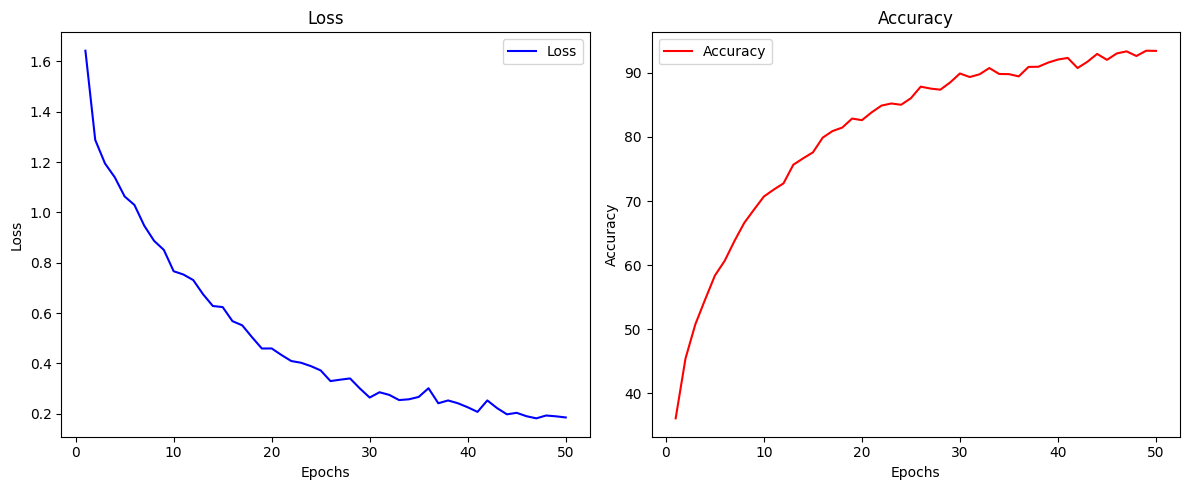

In [10]:
plot_data(loss, accuracy)

In [11]:
validate(improvedCNNModel, testloader, device)

Accuracy: 87.20 %
Precision: 0.88
Recall: 0.87
Confusion Matrix (Normalized):
[[0.82 0.1  0.05 0.01 0.03]
 [0.08 0.88 0.03 0.   0.01]
 [0.1  0.03 0.82 0.   0.05]
 [0.02 0.01 0.   0.97 0.01]
 [0.04 0.03 0.04 0.01 0.88]]
